In [1]:
import os, sys
sys.path.append('../../')
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from adjustText import adjust_text
from utils.evaluate import get_dpc_clusters
from utils.evaluate import get_dpc_unassigned
from utils.evaluate import get_jsdiv
basemap = cx.providers.CartoDB.VoyagerNoLabels

In [2]:
pth = os.path.join('..', '..', 'data', 'training_us.gpkg')
gdf_us = gpd.read_file(pth); gdf_us

,city,state,country,latitude,longitude,population,msa,fold,geometry
0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...,1,POINT (-8207971.222 5067414.863)
1,seven hills,ohio,united states,41.39533,-81.67624,11690,None,2,POINT (-9092157.447 5070828.79)
2,new martinsville,west virginia,united states,39.64452,-80.85760,5218,None,1,POINT (-9001026.859 4814418.565)
3,jacksonville,oregon,united states,42.31346,-122.96699,2883,Jacksonville FL MSA,1,POINT (-13688622.711 5208050.499)
4,tigerville,south carolina,united states,35.06845,-82.36845,1312,Greenville-Mauldin-Easley SC MSA,1,POINT (-9169213.911 4173187.121)
...,...,...,...,...,...,...,...,...,...
7151,mansfield,texas,united states,32.56319,-97.14168,64274,Mansfield OH MSA,2,POINT (-10813762.352 3837467.237)
7152,belfast,maine,united states,44.42591,-69.00642,6682,None,1,POINT (-7681759.536 5531591.056)
7153,flushing,michigan,united states,43.06308,-83.85107,8086,Wheeling WV-OH MSA,1,POINT (-9334258.415 5321578.2)
7154,stone mountain,georgia,united states,33.80816,-84.17020,6109,Atlanta-Sandy Springs-Marietta GA MSA,2,POINT (-9369783.804 4003071.597)


In [3]:
# split MSA (2+ cities) vs. others
msa_msk = ~gdf_us.msa.isna() & gdf_us.msa.duplicated(keep = False)
gdf_us_msa = gdf_us.loc[msa_msk].copy()
gdf_us_other = gdf_us.loc[~msa_msk].copy()

In [4]:
gdf_us_msa

,city,state,country,latitude,longitude,population,msa,fold,geometry
0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...,1,POINT (-8207971.222 5067414.863)
3,jacksonville,oregon,united states,42.31346,-122.96699,2883,Jacksonville FL MSA,1,POINT (-13688622.711 5208050.499)
4,tigerville,south carolina,united states,35.06845,-82.36845,1312,Greenville-Mauldin-Easley SC MSA,1,POINT (-9169213.911 4173187.121)
6,yorktown,indiana,united states,40.17365,-85.49414,11231,Muncie IN MSA,1,POINT (-9517164.131 4891208.804)
7,marlborough,connecticut,united states,41.63310,-72.45470,6368,Hartford-West Hartford-East Hartford CT MSA,1,POINT (-8065620.31 5106177.069)
...,...,...,...,...,...,...,...,...,...
7150,villa rica,georgia,united states,33.73205,-84.91911,14904,Atlanta-Sandy Springs-Marietta GA MSA,2,POINT (-9453152.084 3992879.385)
7151,mansfield,texas,united states,32.56319,-97.14168,64274,Mansfield OH MSA,2,POINT (-10813762.352 3837467.237)
7153,flushing,michigan,united states,43.06308,-83.85107,8086,Wheeling WV-OH MSA,1,POINT (-9334258.415 5321578.2)
7154,stone mountain,georgia,united states,33.80816,-84.17020,6109,Atlanta-Sandy Springs-Marietta GA MSA,2,POINT (-9369783.804 4003071.597)


In [5]:
gdf_us_other

,city,state,country,latitude,longitude,population,msa,fold,geometry
1,seven hills,ohio,united states,41.39533,-81.67624,11690,None,2,POINT (-9092157.447 5070828.79)
2,new martinsville,west virginia,united states,39.64452,-80.85760,5218,None,1,POINT (-9001026.859 4814418.565)
5,olivette,missouri,united states,38.66533,-90.37595,7870,None,2,POINT (-10060604.734 4673845.715)
8,fayetteville,west virginia,united states,38.05289,-81.10399,2892,None,1,POINT (-9028454.868 4586900.093)
10,selmer,tennessee,united states,35.17008,-88.59227,4488,None,1,POINT (-9862046.385 4187018.425)
...,...,...,...,...,...,...,...,...,...
7144,ellijay,georgia,united states,34.69481,-84.48215,1680,None,1,POINT (-9404509.919 4122483.998)
7145,haverhill,massachusetts,united states,42.77620,-71.07728,62765,None,1,POINT (-7912286.617 5277969.008)
7148,dudley,massachusetts,united states,42.04510,-71.93007,11165,None,1,POINT (-8007218.765 5167737.601)
7149,commerce,georgia,united states,34.20400,-83.45711,6762,None,2,POINT (-9290402.988 4056227.245)


In [6]:
# compute 'distance per capita' (~inverse density)
gdf_us_msa = get_dpc_clusters(gdf_us_msa, 'msa')
gdf_us_other = get_dpc_unassigned(gdf_us_other, gdf_us_msa, 'msa')

c:\Users\ccrea\Documents\revelio-assignment\notebooks\evaluation\../..\utils\evaluate.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  centroids_map = (gdf.groupby(cluster_key).apply(lambda row: Point(
c:\Users\ccrea\Documents\revelio-assignment\notebooks\evaluation\../..\utils\evaluate.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  centroids = gdf_ref.groupby(cluster_key).apply(lambda row: Point(


In [7]:
gdf_us_msa

,city,state,country,latitude,longitude,population,msa,fold,geometry,msa_ref,dpc,log10_dpc
6727,whitehouse station,new jersey,united states,40.61538,-74.77044,2089,New York-Northern New Jersey-Long Island NY-NJ...,1,POINT (-8323407.307 4955774.763),New York-Northern New Jersey-Long Island NY-NJ...,0.000088,-4.056829
5537,el paso,texas,united states,31.75872,-106.48693,681124,El Paso TX MSA,2,POINT (-11854070.824 3731680.382),El Paso TX MSA,0.000186,-3.729801
4959,lemont,illinois,united states,41.67364,-88.00173,16788,Chicago-Naperville-Joliet IL-IN-WI MSA,2,POINT (-9796307.773 5112216.974),Chicago-Naperville-Joliet IL-IN-WI MSA,0.000323,-3.490176
6788,annandale,new jersey,united states,40.64093,-74.88128,1695,New York-Northern New Jersey-Long Island NY-NJ...,1,POINT (-8335745.96 4959522.319),New York-Northern New Jersey-Long Island NY-NJ...,0.000483,-3.316366
5592,bridgewater,new jersey,united states,40.60079,-74.64815,44464,New York-Northern New Jersey-Long Island NY-NJ...,1,POINT (-8309794.047 4953635.412),New York-Northern New Jersey-Long Island NY-NJ...,0.000581,-3.235709
...,...,...,...,...,...,...,...,...,...,...,...,...
6232,live oak,florida,united states,30.29495,-82.98402,6931,Yuba City CA MSA,2,POINT (-9237738.85 3541519.537),Yuba City CA MSA,39.932914,1.601331
3396,watkinsville,georgia,united states,33.86290,-83.40877,2872,Athens-Clark County GA MSA,2,POINT (-9285021.804 4010407.668),Athens-Clark County GA MSA,40.242606,1.604686
6345,redding,connecticut,united states,41.30510,-73.39160,9176,Redding CA MSA,1,POINT (-8169915.541 5057448.537),Redding CA MSA,45.084390,1.654026
6046,logan,ohio,united states,39.54007,-82.40710,7117,Logan UT-ID MSA,1,POINT (-9173516.41 4799329.881),Logan UT-ID MSA,46.454638,1.667029


In [8]:
gdf_us_other

,city,state,country,latitude,longitude,population,msa,fold,geometry,msa_ref,dpc,log10_dpc
6998,branchburg,new jersey,united states,40.56290,-74.71400,14480,None,1,POINT (-8317124.435 4948081.731),New York-Northern New Jersey-Long Island NY-NJ...,0.000417,-3.379416
3408,highland,california,united states,34.12834,-117.20865,54854,None,2,POINT (-13047607.235 4046047.998),Los Angeles-Long Beach-Santa Ana CA MSA,0.000783,-3.105970
4805,wauwatosa,wisconsin,united states,43.04946,-88.00759,47614,None,1,POINT (-9796960.105 5319503.196),Milwaukee-Waukesha-West Allis WI MSA,0.000851,-3.070184
301,green brook,new jersey,united states,40.60380,-74.48250,7114,None,1,POINT (-8291353.973 4954076.734),New York-Northern New Jersey-Long Island NY-NJ...,0.001309,-2.882973
2565,burr ridge,illinois,united states,41.74892,-87.91839,10818,None,2,POINT (-9787030.406 5123442.764),Chicago-Naperville-Joliet IL-IN-WI MSA,0.001390,-2.857098
...,...,...,...,...,...,...,...,...,...,...,...,...
14,haines,alaska,united states,59.23595,-135.44533,1713,None,2,POINT (-15077705.166 8231560.444),Fairbanks AK MSA,39.557777,1.597232
2412,skagway,alaska,united states,59.45833,-135.31389,920,None,2,POINT (-15063073.332 8280115.992),Fairbanks AK MSA,39.642937,1.598166
799,gustavus,alaska,united states,58.41333,-135.73694,434,None,1,POINT (-15110167.043 8054651.12),Fairbanks AK MSA,39.862753,1.600567
6195,sitka,alaska,united states,57.05315,-135.33088,8863,None,2,POINT (-15064964.65 7770989.839),Fairbanks AK MSA,42.871119,1.632165


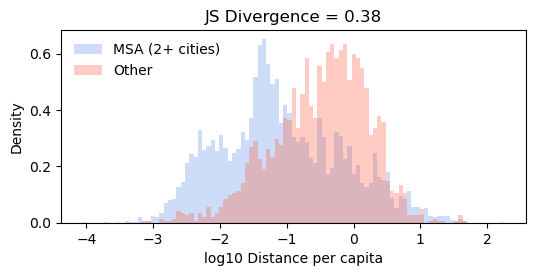

In [9]:
jsdiv, ax = get_jsdiv(gdf_us_msa,
                      gdf_us_other,
                      'log10_dpc',
                      n_bins = 100,
                      plot = True,
                      return_ax = True,
                      gdf1_label = 'MSA (2+ cities)',
                      gdf2_label = 'Other')

ax.legend(frameon = False)
ax.set_title(f'JS Divergence = {jsdiv.round(2)}')
ax.set_xlabel('log10 Distance per capita')
ax.set_ylabel('Density')
plt.show()

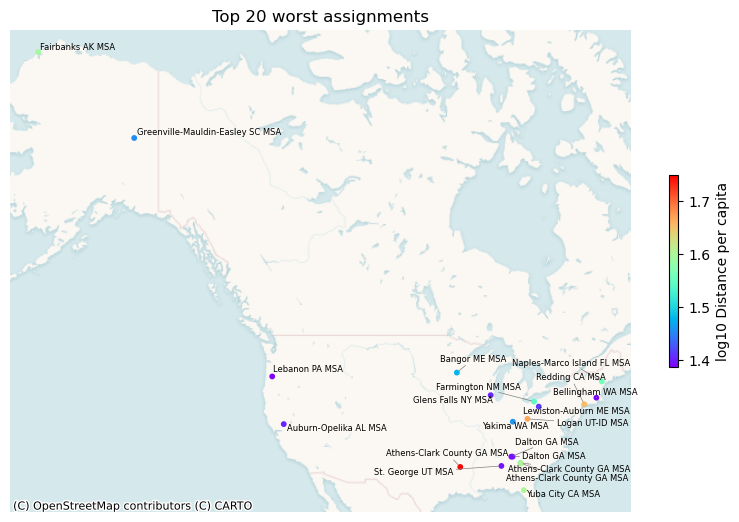

In [12]:
# worst MSA assignments by dpc
top_n, ms, fs = 20, 10., 6.
gdf_plt = gdf_us_msa.tail(top_n)
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
gdf_plt.plot(column = 'log10_dpc',
             cmap = 'rainbow',
             vmax = 1.75,
             markersize = ms,
             legend = True,
             legend_kwds = {'label': 'log10 Distance per capita', 'shrink' : .25},
             ax = ax)
cx.add_basemap(ax, source = basemap)
labels = [ax.text(row.geometry.x, row.geometry.y, row.msa, fontsize = fs)
          for _, row in gdf_plt.iterrows()]
adjust_text(labels, ax = ax, arrowprops = dict(arrowstyle = '-', color = 'gray', lw = .5))
ax.set_title(f'Top {top_n} worst assignments')
ax.axis(False)
plt.show()

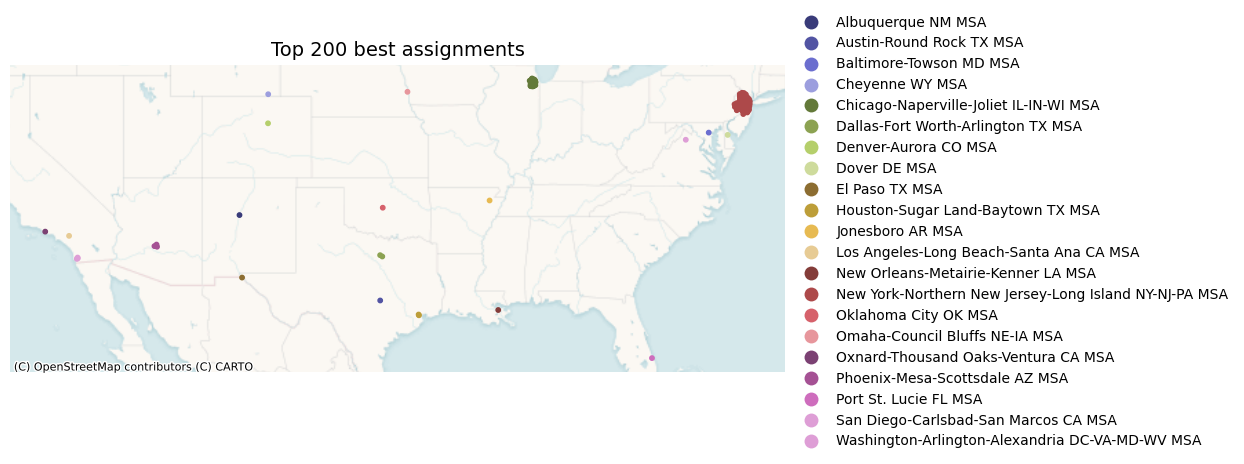

In [15]:
# best MSA assignments by dpc
top_n = 200
gdf_plt = gdf_us_msa.head(top_n)
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
gdf_plt.plot(column = 'msa',
             cmap = 'tab20b',
             markersize = ms,
             legend = True,
             ax = ax)
cx.add_basemap(ax, source = basemap)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1.2))
leg.set_frame_on(False)
ax.set_title(f'Top {top_n} best assignments', size = 14)
ax.axis(False)
plt.show()